<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/5_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Lesions Classifications using pretrained network DenseNet

## Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
import os
import math
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/DenseNet"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Utility

In [ ]:
def compile_model(model, metrics='accuracy', loss='sparse_categorical_crossentropy', optimizer='adam', learning_rate = 0.001):
  '''
    compile_model is used to compile the current model
    :param model: model to compile
    :param optimizer: optimizer to be used
    :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    optimizer=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  else:
    return

  model.compile(loss=loss,
    optimizer=optimizer,
    metrics=[metrics])

  return model

def run_model (model, model_name, train_ds, val_ds, epochs=50, patience=3, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
           
  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks_list,
                    class_weight=class_weight
                    )
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  return tf.keras.models.load_model(save_path), history


def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight

# actually compute the CLASS WEIGHTS
labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

## Feature Extraction

Let's use the DenseNet as Feature Extractor.

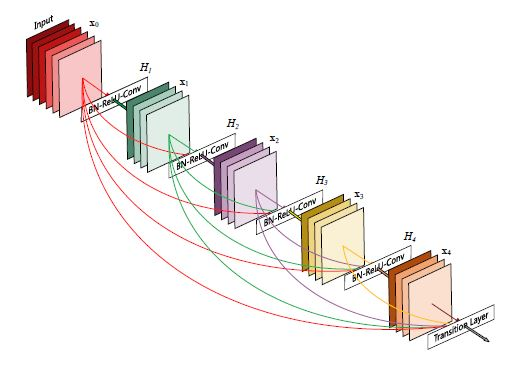

In [ ]:
densenet = keras.applications.DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)
)

densenet.trainable = False
densenet.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

###Dense

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.densenet.preprocess_input(inputs)
x = densenet(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="DenseNet")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
model, history = run_model(model, "Dense", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 1.3957 - accuracy: 0.6391
Epoch 1: val_loss improved from inf to 0.85902, saving model to /content/models/Dense.h5
220/220 [==============================] - 38s 146ms/step - loss: 1.3958 - accuracy: 0.6393 - val_loss: 0.8590 - val_accuracy: 0.6720
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.0683 - accuracy: 0.7018
Epoch 2: val_loss improved from 0.85902 to 0.83657, saving model to /content/models/Dense.h5
220/220 [==============================] - 30s 132ms/step - loss: 1.0679 - accuracy: 0.7017 - val_loss: 0.8366 - val_accuracy: 0.6813
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.7412
Epoch 3: val_loss improved from 0.83657 to 0.73514, saving model to /content/models/Dense.h5
220/220 [==============================] - 30s 132ms/step - loss: 0.9503 - accuracy: 0.7412 - val_loss: 0.7351 - val_accuracy: 0.7140
Epoch 4/50
219/220 [===============

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 7s 110ms/step - loss: 0.6770 - accuracy: 0.7538
Loss on test set: 0.67701256275177
Accuracy on test set: 0.75380539894104
                precision    recall  f1-score   support

       Actinic     0.4634    0.3800    0.4176        50
           BCC     0.5890    0.5375    0.5621        80
Dermatofibroma     0.2500    0.3333    0.2857        18
     Keratosis     0.4706    0.6265    0.5375       166
      Melanoma     0.4516    0.4167    0.4334       168
          Nevu     0.9042    0.8719    0.8878      1007
      Vascular     0.7308    0.8636    0.7917        22

      accuracy                         0.7538      1511
     macro avg     0.5514    0.5756    0.5594      1511
  weighted avg     0.7647    0.7538    0.7574      1511



48/48 [==============================] - 5s 111ms/step


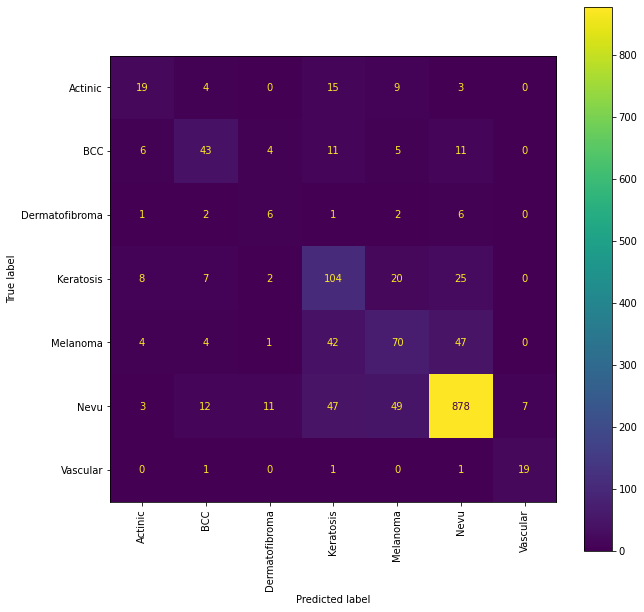

In [ ]:
plot_confusionmatrix(model, test_images)

### Dense Layer and Dropout

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.densenet.preprocess_input(inputs)
x = densenet(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(DROPOUT)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="DenseNet")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
model, history = run_model(model, "DenseDropout", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 1.4877 - accuracy: 0.6237
Epoch 1: val_loss improved from inf to 1.00187, saving model to /content/models/Dense.h5
220/220 [==============================] - 38s 141ms/step - loss: 1.4869 - accuracy: 0.6236 - val_loss: 1.0019 - val_accuracy: 0.6040
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.1545 - accuracy: 0.6872
Epoch 2: val_loss improved from 1.00187 to 0.75709, saving model to /content/models/Dense.h5
220/220 [==============================] - 30s 132ms/step - loss: 1.1546 - accuracy: 0.6873 - val_loss: 0.7571 - val_accuracy: 0.7273
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 1.0573 - accuracy: 0.7036
Epoch 3: val_loss did not improve from 0.75709
220/220 [==============================] - 29s 129ms/step - loss: 1.0572 - accuracy: 0.7039 - val_loss: 0.8134 - val_accuracy: 0.6933
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.9740 - ac

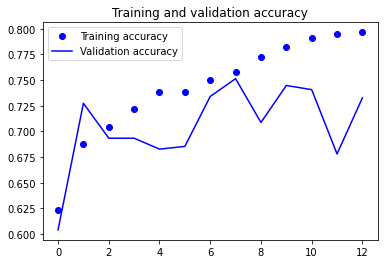

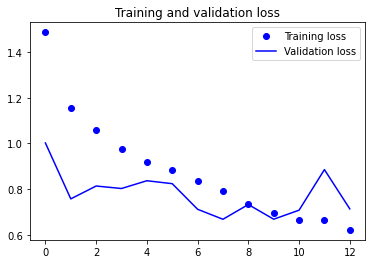

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 7s 112ms/step - loss: 0.6523 - accuracy: 0.7637
Loss on test set: 0.6523261070251465
Accuracy on test set: 0.7637326121330261
                precision    recall  f1-score   support

       Actinic     0.5000    0.3400    0.4048        50
           BCC     0.4385    0.7125    0.5429        80
Dermatofibroma     0.2917    0.3889    0.3333        18
     Keratosis     0.5763    0.4096    0.4789       166
      Melanoma     0.5030    0.5000    0.5015       168
          Nevu     0.8938    0.8947    0.8943      1007
      Vascular     0.6667    0.9091    0.7692        22

      accuracy                         0.7637      1511
     macro avg     0.5528    0.5936    0.5607      1511
  weighted avg     0.7679    0.7637    0.7617      1511



48/48 [==============================] - 5s 112ms/step


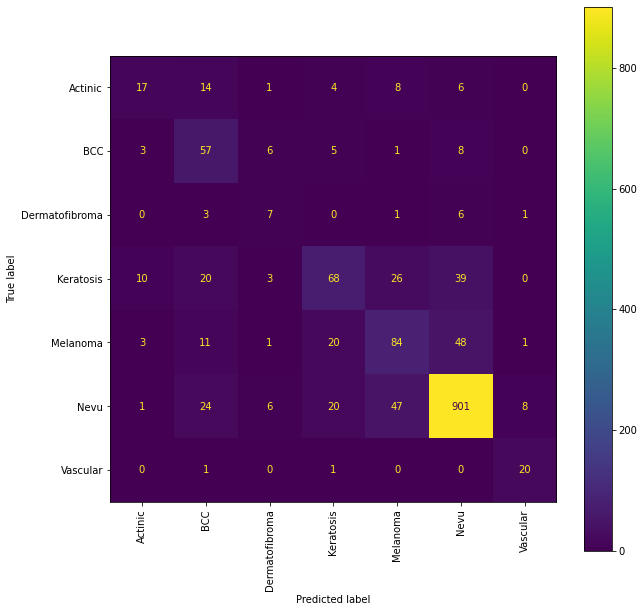

In [ ]:
plot_confusionmatrix(model, test_images)

## Fine Tuning

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/DenseNet/DenseDropout.h5')

### Last Block

In [ ]:
trainable = False

for layer in model.get_layer("densenet121").layers:
    if layer.name == 'conv5_block15_0_bn':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
model, history = run_model(model, "FT_Last1", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8884
Epoch 1: val_loss improved from inf to 0.68834, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 38s 145ms/step - loss: 0.3224 - accuracy: 0.8885 - val_loss: 0.6883 - val_accuracy: 0.7513
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.2799 - accuracy: 0.8995
Epoch 2: val_loss improved from 0.68834 to 0.63456, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 32s 143ms/step - loss: 0.2797 - accuracy: 0.8996 - val_loss: 0.6346 - val_accuracy: 0.7800
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.2424 - accuracy: 0.9115
Epoch 3: val_loss did not improve from 0.63456
220/220 [==============================] - 31s 137ms/step - loss: 0.2423 - accuracy: 0.9116 - val_loss: 0.7799 - val_accuracy: 0.7513
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.219

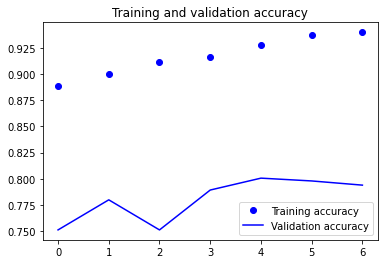

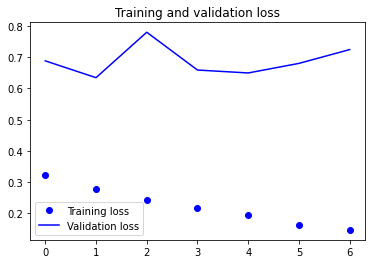

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 110ms/step - loss: 0.6500 - accuracy: 0.8074
Loss on test set: 0.6500093340873718
Accuracy on test set: 0.807412326335907
                precision    recall  f1-score   support

       Actinic     0.5750    0.4600    0.5111        50
           BCC     0.7377    0.5625    0.6383        80
Dermatofibroma     0.6364    0.3889    0.4828        18
     Keratosis     0.5941    0.7229    0.6522       166
      Melanoma     0.5266    0.5298    0.5282       168
          Nevu     0.9133    0.9106    0.9120      1007
      Vascular     0.7917    0.8636    0.8261        22

      accuracy                         0.8074      1511
     macro avg     0.6821    0.6340    0.6501      1511
  weighted avg     0.8097    0.8074    0.8066      1511



48/48 [==============================] - 5s 112ms/step


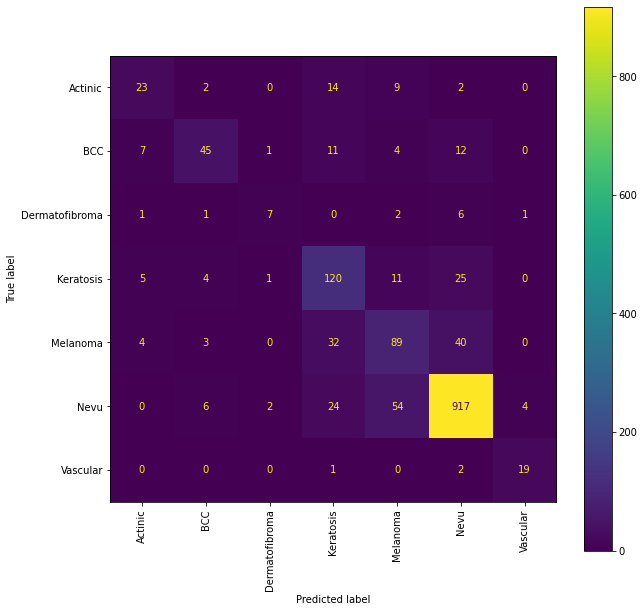

In [ ]:
plot_confusionmatrix(model, test_images)

### Last 3 Blocks

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/DenseNet/DenseDropout.h5')

In [ ]:
trainable = False

for layer in model.get_layer("densenet121").layers:
    if layer.name == 'conv5_block13_0_bn':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
model, history = run_model(model, "FT_Last3", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7904
Epoch 1: val_loss improved from inf to 0.67265, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 41s 156ms/step - loss: 0.7180 - accuracy: 0.7904 - val_loss: 0.6727 - val_accuracy: 0.7373
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.6171 - accuracy: 0.8069
Epoch 2: val_loss did not improve from 0.67265
220/220 [==============================] - 30s 134ms/step - loss: 0.6178 - accuracy: 0.8070 - val_loss: 0.7915 - val_accuracy: 0.7047
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.5544 - accuracy: 0.8189
Epoch 3: val_loss improved from 0.67265 to 0.66496, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 31s 137ms/step - loss: 0.5540 - accuracy: 0.8191 - val_loss: 0.6650 - val_accuracy: 0.7493
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.475

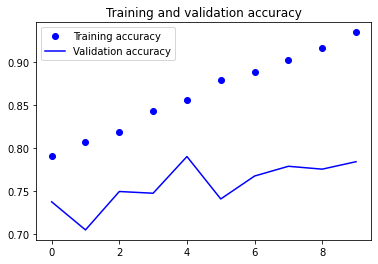

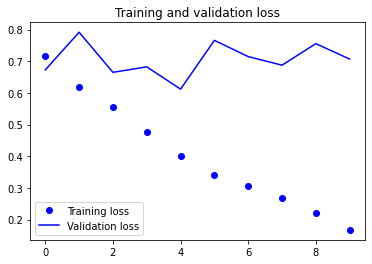

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 132ms/step - loss: 0.6187 - accuracy: 0.7929
Loss on test set: 0.6186519265174866
Accuracy on test set: 0.7928524017333984
                precision    recall  f1-score   support

       Actinic     0.6000    0.4200    0.4941        50
           BCC     0.5833    0.7875    0.6702        80
Dermatofibroma     0.3182    0.3889    0.3500        18
     Keratosis     0.5545    0.7048    0.6207       166
      Melanoma     0.6420    0.3095    0.4177       168
          Nevu     0.8914    0.9126    0.9019      1007
      Vascular     0.8261    0.8636    0.8444        22

      accuracy                         0.7929      1511
     macro avg     0.6308    0.6267    0.6141      1511
  weighted avg     0.7929    0.7929    0.7840      1511



48/48 [==============================] - 5s 111ms/step


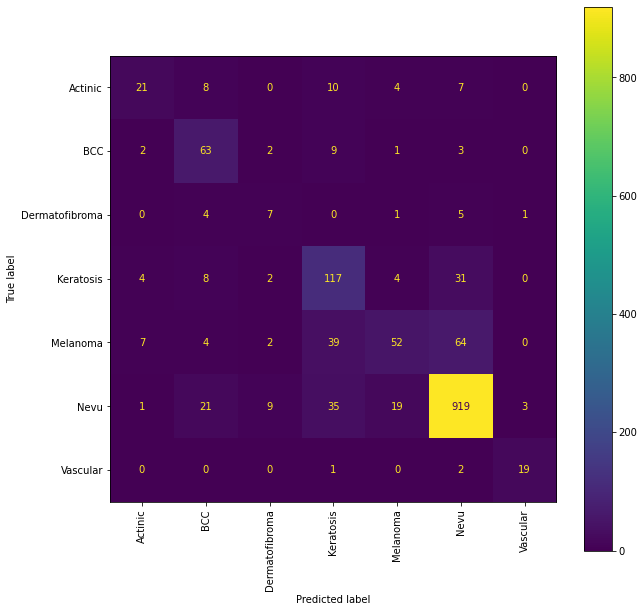

In [ ]:
plot_confusionmatrix(model, test_images)

### Last Conv Block

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/DenseNet/DenseDropout.h5')

In [ ]:
trainable = False

for layer in model.get_layer("densenet121").layers:
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if 'conv5' in layer._name and not is_bn:
        layer.trainable = True

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "DenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
model, history = run_model(model, "FT_LastWhole", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.7681 - accuracy: 0.7740
Epoch 1: val_loss improved from inf to 0.66000, saving model to /content/models/FT_LastWhole.h5
220/220 [==============================] - 2039s 9s/step - loss: 0.7681 - accuracy: 0.7740 - val_loss: 0.6600 - val_accuracy: 0.7547
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.5687 - accuracy: 0.8193
Epoch 2: val_loss improved from 0.66000 to 0.65302, saving model to /content/models/FT_LastWhole.h5
220/220 [==============================] - 32s 143ms/step - loss: 0.5690 - accuracy: 0.8192 - val_loss: 0.6530 - val_accuracy: 0.7460
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.4382 - accuracy: 0.8522
Epoch 3: val_loss improved from 0.65302 to 0.62037, saving model to /content/models/FT_LastWhole.h5
220/220 [==============================] - 32s 143ms/step - loss: 0.4379 - accuracy: 0.8522 - val_loss: 0.6204 - val_accuracy: 0.7700
Epoch 4/50
219/

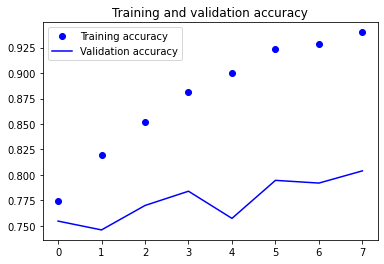

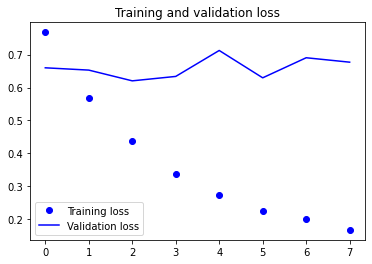

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 359s 7s/step - loss: 0.6275 - accuracy: 0.7823
Loss on test set: 0.6274610161781311
Accuracy on test set: 0.7822633981704712
                precision    recall  f1-score   support

       Actinic     0.5758    0.3800    0.4578        50
           BCC     0.6933    0.6500    0.6710        80
Dermatofibroma     0.5385    0.3889    0.4516        18
     Keratosis     0.5777    0.7169    0.6398       166
      Melanoma     0.4430    0.6250    0.5185       168
          Nevu     0.9328    0.8550    0.8922      1007
      Vascular     0.7917    0.8636    0.8261        22

      accuracy                         0.7823      1511
     macro avg     0.6504    0.6399    0.6367      1511
  weighted avg     0.8081    0.7823    0.7906      1511



48/48 [==============================] - 5s 109ms/step


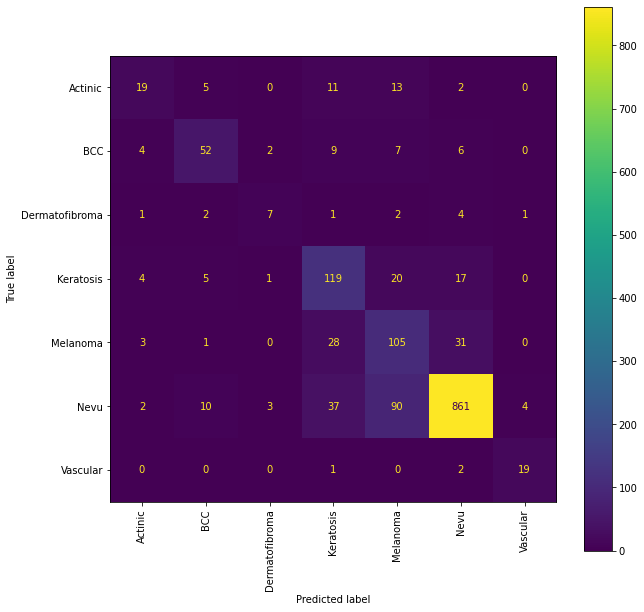

In [ ]:
plot_confusionmatrix(model, test_images)